In [17]:
!pip install ucimlrepo

In [18]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

forest_fires = fetch_ucirepo(id=162)
forest_fires

{'data': {'ids': None,
  'features':      X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain
  0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0
  1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0
  2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0
  3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2
  4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0
  ..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...
  512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0
  513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0
  514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0
  515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0
  516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0
  
  [517 rows x 12 columns],
  'targets':       area
  0     0.00
  1     0.00
  2     0.00
  3     0.00
  4    

In [19]:
X = forest_fires.data.features
y = forest_fires.data.targets.values
print(X)
# из задания было видно, что задача регрессии, здесь в этом убедились
print(type(y[0][0]))

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0

[517 rows x 12 columns]
<class 'numpy.float64'>


In [20]:
# видно, что day и month - категориальные признаки, т.к. они взаимозависимы, то LE, а не OHE
label_encoder = LabelEncoder()
X['month'] = label_encoder.fit_transform(X['month'])
X['day'] = label_encoder.fit_transform(X['day'])

scaler = StandardScaler()
X = scaler.fit_transform(X)

/tmp/ipython-input-3882815938.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'] = label_encoder.fit_transform(X['month'])
/tmp/ipython-input-3882815938.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['day'] = label_encoder.fit_transform(X['day'])


In [21]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# создадим тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [22]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [23]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_mlp(model, X_train, y_train, epochs=2000, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in tqdm(range(epochs), desc="Training MLP"):
        model.train()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    plt.plot(range(epochs), losses, label="MLP Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"Final Loss: {losses[-1]}")

    return losses

In [24]:
import torch.optim as optim

input_size = X_train.shape[1]
model = MLP(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training MLP: 100%|██████████| 2000/2000 [00:08<00:00, 238.01it/s]


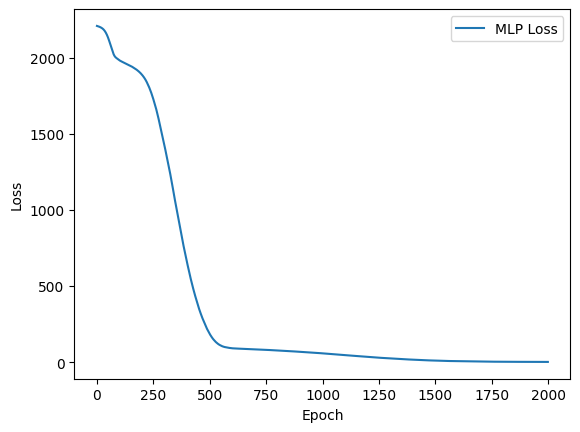

Final Loss: 1.5224436521530151


In [25]:
input_size = X_train.shape[1]
model = MLP(input_size)

losses = train_mlp(model, X_train, y_train)

In [26]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

n = 10
print([round(float(_[0]), 2) for _ in y_test_pred[:n]])
print([round(float(_[0]), 2) for _ in y_test[:n]])

Test Loss: 14409.0840
[0.05, -1.0, 0.05, 5.56, 21.23, -0.07, 8.52, -12.26, 0.26, -8.92]
[0.0, 0.0, 1.23, 1.46, 1.95, 0.0, 13.99, 6.44, 0.0, 0.75]


In [27]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        encoded = self.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [28]:
def train_autoencoder(autoencoder, data, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    losses = []
    for epoch in tqdm(range(epochs), desc="Training Autoencoder"):
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    plt.plot(range(epochs), losses, label="Autoencoder Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return autoencoder.encoder.weight.detach(), autoencoder.encoder.bias.detach()

In [29]:
def layerwise_training(data, model):
    autoencoder1 = Autoencoder(input_size=data.shape[1], hidden_size=64)
    weight1, bias1 = train_autoencoder(autoencoder1, data)
    model.fc1.weight.data = weight1
    model.fc1.bias.data = bias1
    with torch.no_grad():
        data_transformed = model.relu(model.fc1(data))
    autoencoder2 = Autoencoder(input_size=64, hidden_size=32)
    weight2, bias2 = train_autoencoder(autoencoder2, data_transformed)
    model.fc2.weight.data = weight2
    model.fc2.bias.data = bias2
    return model

In [30]:
def layerwise_pretraining(data, model):
    print("Pretraining layer fc1...")
    ae1 = Autoencoder(input_size=data.shape[1], hidden_size=64)
    w1, b1 = train_autoencoder(ae1, data, epochs=100)
    model.fc1.weight.data = w1
    model.fc1.bias.data = b1
    with torch.no_grad():
        data = model.relu(model.fc1(data))

    print("Pretraining layer fc2...")
    ae2 = Autoencoder(input_size=64, hidden_size=32)
    w2, b2 = train_autoencoder(ae2, data, epochs=100)
    model.fc2.weight.data = w2
    model.fc2.bias.data = b2
    with torch.no_grad():
        data = model.relu(model.fc2(data))

    print("Pretraining layer fc3...")
    ae3 = Autoencoder(input_size=32, hidden_size=16)
    w3, b3 = train_autoencoder(ae3, data, epochs=100)
    model.fc3.weight.data = w3
    model.fc3.bias.data = b3

    return model

Pretraining layer fc1...


Training Autoencoder: 100%|██████████| 100/100 [00:00<00:00, 368.48it/s]


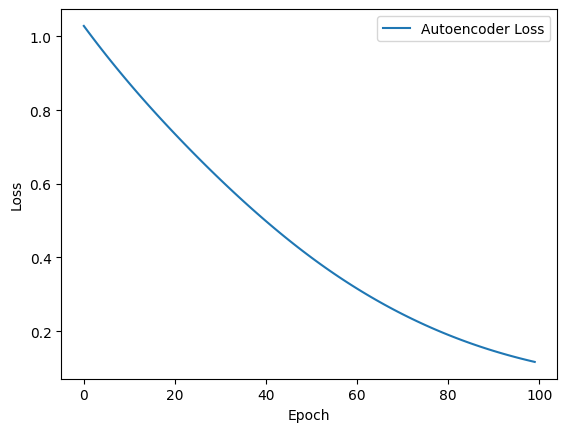

Pretraining layer fc2...


Training Autoencoder: 100%|██████████| 100/100 [00:00<00:00, 459.87it/s]


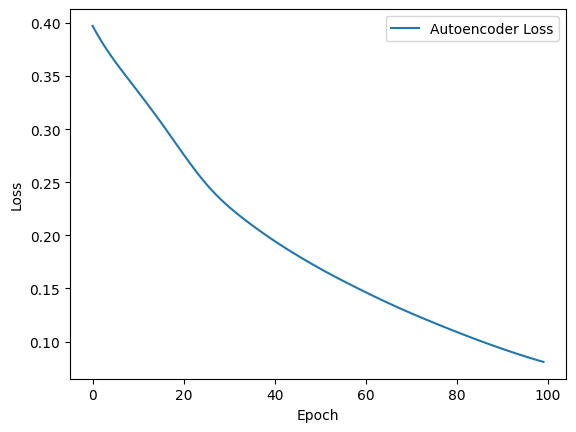

Pretraining layer fc3...


Training Autoencoder: 100%|██████████| 100/100 [00:00<00:00, 456.65it/s]


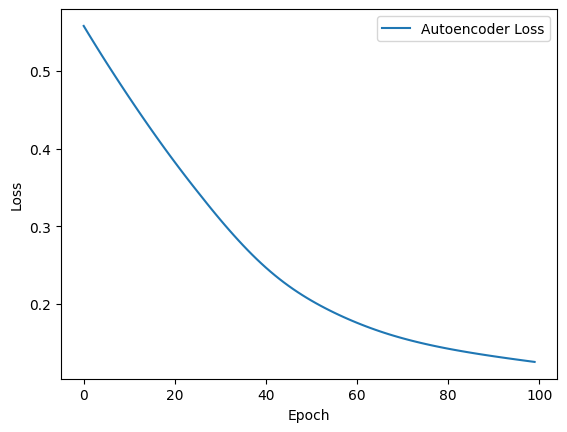

Starting Fine-Tuning...


Training MLP: 100%|██████████| 200/200 [00:00<00:00, 226.60it/s]


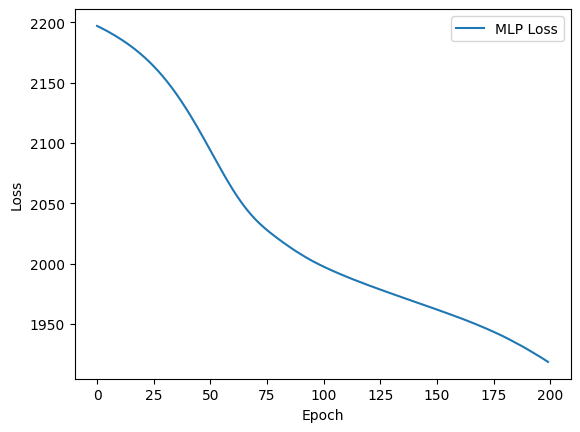

Final Loss: 1918.4954833984375
Test Loss after Fine-Tuning: 11755.4053
Predictions: [7.59, 12.13, 34.49, 5.62, 16.8, 3.45, 3.01, 8.82, 8.01, 1.09]
True values: [0.0, 0.0, 1.23, 1.46, 1.95, 0.0, 13.99, 6.44, 0.0, 0.75]


In [31]:
input_size = X_train.shape[1]
model = MLP(input_size)
model = layerwise_pretraining(X_train, model)

print("Starting Fine-Tuning...")
losses_finetune = train_mlp(model, X_train, y_train, epochs=200, lr=0.001)

model.eval()
criterion = nn.MSELoss()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss after Fine-Tuning: {test_loss.item():.4f}')